# Trying to get learning of angles working

Let's go back to basics, ignore the probabilistic stuff and just try to get a NN to learn the angles of MNIST digits. 

In [79]:
%load_ext autoreload
%autoreload 2

import os

os.environ["WANDB_NOTEBOOK_NAME"] = "selfsupervised.ipynb"
os.environ["XLA_FLAGS"] = "--xla_gpu_deterministic_ops=true"

from typing import Optional, Union

from ml_collections import config_dict
import jax.random as random
import jax.numpy as jnp

jnp.log(jnp.exp(1) - 1.0)
# TODO: figure out why we get CUDA failures this ^ isn't here. 

import flax
from flax.training import train_state

import ciclo
import optax
import distrax

import jax
from jax import lax
import flax
import flax.linen as nn

from clu import parameter_overview

from typing import Any

from functools import partial

import tensorflow_datasets as tfds

from clu import deterministic_data
from clu import preprocess_spec
from clu import metrics

from absl import logging
logging.set_verbosity(logging.INFO)

# set save plot face color to be white
import matplotlib.pyplot as plt
plt.rcParams["savefig.facecolor"] = "white"

from src.utils.preprocess import all_ops
from src.utils.training import setup_model, get_dataset_splits, train_loop
import src.utils.input as input_utils
from src.models.common import ResNet18
from src.transformations import transform_image


PRNGKey = Any

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [80]:
rng = random.PRNGKey(0)
train_data_rng, val_data_rng, init_rng, state_rng = random.split(rng, 4)

## Get data

In [81]:
ANGLE = 180

dataset_config = config_dict.ConfigDict()
dataset_config.batch_size = 512
dataset_config.dataset = "MNIST"
dataset_config.shuffle_buffer_size = 50_000
dataset_config.repeat_after_batching = True  # NOTE: ordering of PP, shuffle, and repeat is important!
dataset_config.train_split = f"train[10000:]"
dataset_config.pp_train = f'value_range(-1, 1)|random_rotate(-{ANGLE}, {ANGLE}, fill_value=-1)|keep(["image"])'
dataset_config.val_split = f"train[:10000]"
dataset_config.pp_eval = f'value_range(-1, 1)|random_rotate(-{ANGLE}, {ANGLE}, fill_value=-1)|keep(["image", "label"])'


In [82]:
# train_ds, val_ds, _ = get_dataset_splits(dataset_config, data_rng, dataset_config.batch_size, dataset_config.batch_size)

In [83]:
def get_data(dataset_config):
    dataset_builder = tfds.builder(dataset_config.dataset)
    dataset_builder.download_and_prepare()

    local_batch_size  = dataset_config.batch_size // jax.device_count()

    train_ds = deterministic_data.create_dataset(
        dataset_builder,
        split=tfds.split_for_jax_process(dataset_config.train_split),
        # This RNG key will be used to derive all randomness in shuffling, data
        # preprocessing etc.
        rng=train_data_rng,
        shuffle_buffer_size=dataset_config.shuffle_buffer_size,
        # Depending on TPU/other runtime, local device count will be 8/1.
        batch_dims=[jax.local_device_count(), local_batch_size],
        repeat_after_batching=False,
        preprocess_fn=preprocess_spec.parse(
            spec=dataset_config.pp_train,
            available_ops=all_ops(),
        ),
        shuffle="loaded",
        )


    num_val_examples = dataset_builder.info.splits[dataset_config.val_split].num_examples
    # Compute how many batches we need to contain the entire val set.
    pad_up_to_batches = int(jnp.ceil(num_val_examples / dataset_config.batch_size))

    val_ds = deterministic_data.create_dataset(
        dataset_builder,
        split=tfds.split_for_jax_process(dataset_config.val_split),
        rng=val_data_rng,
        batch_dims=[jax.local_device_count(), local_batch_size],
        num_epochs=1,
        preprocess_fn=preprocess_spec.parse(
            spec=dataset_config.pp_eval,
            available_ops=all_ops(),
        ),
        # Pad with masked examples instead of dropping incomplete final batch.
        pad_up_to_batches=pad_up_to_batches,
        shuffle=False)

    return train_ds, val_ds

## Setup TrainState and NN

In [84]:
@flax.struct.dataclass  # <-- required for JAX transformations
class Metrics(metrics.Collection):
    loss: metrics.Average.from_output('loss')
    η_mse: metrics.Average.from_output('η_mse')
    x_mse: metrics.Average.from_output('x_mse')

    def update(self, **kwargs) -> "Metrics":
        updates = self.single_from_model_output(**kwargs)
        return self.merge(updates)

class TrainState(train_state.TrainState):
    metrics: Metrics
    rng: PRNGKey
    λ: float
    λ_schedule: optax.Schedule = flax.struct.field(pytree_node=False)
    polyak_step_size: Optional[float] = None
    avg_params: Optional[flax.core.FrozenDict] = None

    def apply_gradients(self, *, grads, **kwargs):
        updates, new_opt_state = self.tx.update(grads, self.opt_state, self.params)
        new_params = optax.apply_updates(self.params, updates)

        if self.polyak_step_size is not None:
            new_avg_params = optax.incremental_update(new_params, self.avg_params, self.polyak_step_size)
        else:
            new_avg_params = None

        return self.replace(
            step=self.step + 1,
            params=new_params,
            opt_state=new_opt_state,
            λ=self.λ_schedule(self.step),
            avg_params=new_avg_params,
            **kwargs,
        )

    @classmethod
    def create(
        cls,
        *,
        apply_fn,
        params,
        tx,
        λ_schedule,
        **kwargs,
    ):
        opt_state = tx.init(params)
        if kwargs.get("polyak_step_size", None) is not None:
            avg_params = params
        else:
            avg_params = None
        return cls(
            step=0,
            apply_fn=apply_fn,
            params=params,
            tx=tx,
            opt_state=opt_state,
            λ_schedule=λ_schedule,
            λ=λ_schedule(0),
            avg_params=avg_params,
            **kwargs,
        )

def reset_metrics(state):
    return state.replace(metrics=state.metrics.empty())

In [85]:
BOUNDS_ARRAY = jnp.array((0.25, 0.25, jnp.pi, 0.25, 0.25))

class MyModel(nn.Module):
    @nn.compact
    def __call__(self, x, train: bool = True):


        # ResNet version
        # h = ResNet18(lowres=True, num_classes=64, num_filters=64)(x, train=train)


        # # CNN version
        h = x

        # for i, conv_dim in enumerate([64, 128, 256]):
        #     h = nn.Conv(
        #         conv_dim,
        #         kernel_size=(3, 3),
        #         strides=(2, 2) if i == 0 else (1, 1),
        #     )(h)
        #     h = nn.LayerNorm()(h)
        #     h = nn.relu(h)

        # ## Fully-conv version
        # h = nn.Conv(BOUNDS_ARRAY.shape[0], kernel_size=(3, 3), strides=(1, 1))(h)
        # features = jnp.mean(h, axis=(0, 1))
        
        # features = jax.nn.tanh(features)
        # return features * BOUNDS_ARRAY


        # ## Standard version 
        # h = nn.Conv(3, kernel_size=(3, 3), strides=(1, 1))(h)

        h = h.flatten()

        for dense_dim in [2048, 1024, 1024, 1024, 1024, 128]:
            h_ = h

            h = nn.Dense(dense_dim)(h)
            # h = nn.LayerNorm()(h)
            h = nn.relu(h)
            h = nn.Dropout(rate=0., deterministic=not train)(h)

            # if h_.shape == h.shape:
            #     h = h + h_


        # Regression version
        features = nn.Dense(
            BOUNDS_ARRAY.shape[0],
            # kernel_init=nn.initializers.zeros_init()
        )(h)

        features = jax.nn.tanh(features)
        return features * BOUNDS_ARRAY



## Supervised learning

In [9]:
train_ds, val_ds = get_data(dataset_config)

INFO:absl:Load dataset info from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Fields info.[citation, splits, supervised_keys, module_name] from disk and from code do not match. Keeping the one from code.
INFO:absl:Reusing dataset mnist (/homes/jua23/tensorflow_datasets/mnist/3.0.1)


INFO:absl:Constructing tf.data.Dataset mnist for split _EvenSplit(split='train[10000:]', index=0, count=1, drop_remainder=False), from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Features before preprocessing: {'image': 'uint8[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op ValueRange(vmin=-1, vmax=1, in_min=0, in_max=255.0, clip_values=False, key='image', key_result=None):
{'image': 'float32[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op RandomRotate(θ_min=-3.141592653589793, θ_max=3.141592653589793, fill_mode='nearest', fill_value=-1, key='image', key_result=None, rng_key='rng'):
{'image': 'float32[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op Keep(keys=['image']):
{'image': 'float32[28, 28, 1]'}
INFO:absl:Features after preprocessing: {'image': 'float32[28, 28, 1]'}
INFO:absl:Constructing tf.data.Dataset mnist for split _EvenSplit(split='train[:10000]', index=0, count=1, dro

In [10]:
model = MyModel()

variables = model.init(init_rng, jnp.empty((28, 28, 2)), train=False)

parameter_overview.log_parameter_overview(variables)

INFO:absl:
+-----------------------+--------------+-----------+-----------+--------+
| Name                  | Shape        | Size      | Mean      | Std    |
+-----------------------+--------------+-----------+-----------+--------+
| params/Dense_0/bias   | (2048,)      | 2,048     | 0.0       | 0.0    |
| params/Dense_0/kernel | (1568, 2048) | 3,211,264 | -9.56e-06 | 0.0252 |
| params/Dense_1/bias   | (1024,)      | 1,024     | 0.0       | 0.0    |
| params/Dense_1/kernel | (2048, 1024) | 2,097,152 | 1.31e-05  | 0.0221 |
| params/Dense_2/bias   | (1024,)      | 1,024     | 0.0       | 0.0    |
| params/Dense_2/kernel | (1024, 1024) | 1,048,576 | -6.31e-06 | 0.0313 |
| params/Dense_3/bias   | (1024,)      | 1,024     | 0.0       | 0.0    |
| params/Dense_3/kernel | (1024, 1024) | 1,048,576 | 1.18e-05  | 0.0312 |
| params/Dense_4/bias   | (1024,)      | 1,024     | 0.0       | 0.0    |
| params/Dense_4/kernel | (1024, 1024) | 1,048,576 | 1.47e-05  | 0.0313 |
| params/Dense_5/bias   | (

In [11]:
TOTAL_STEPS = 5_000
LR = 1e-4

state = TrainState.create(
    apply_fn=model.apply,
    params=variables["params"],
    tx=optax.inject_hyperparams(optax.adamw)(LR),
    metrics=Metrics.empty(),
    rng=state_rng,
    λ_schedule=optax.cosine_decay_schedule(1, TOTAL_STEPS, 1)
)

In [12]:
def loss_fn(x, params, state, step_rng, train):
    rng_local = random.fold_in(step_rng, lax.axis_index("batch"))
    rng_dropout, rng_η = random.split(rng_local)

    Η_rand = distrax.Uniform(low=-BOUNDS_ARRAY, high=BOUNDS_ARRAY)
    η_rand = Η_rand.sample(seed=rng_η, sample_shape=())
    x_rand = transform_image(x, η_rand)

    mask = distrax.Bernoulli(probs=state.λ).sample(seed=rng_dropout)

    η_x_rand = state.apply_fn(
        {"params": params},
        jnp.concatenate([x_rand, (x_rand - x)*mask], axis=-1),
        train, rngs={"dropout": rng_dropout}
    )

    η_mse = optax.squared_error(η_rand - η_x_rand).mean()
    x_mse = optax.squared_error(x, transform_image(x, η_rand - η_x_rand)).mean()

    loss = η_mse

    return loss, {"loss": loss, "η_mse": η_mse, "x_mse": x_mse}


@jax.jit
def train_step(state, batch):
    step_rng = random.fold_in(state.rng, state.step)

    def batch_loss_fn(params):
        losses, metrics = jax.vmap(loss_fn, in_axes=(0, None, None, None, None), axis_name="batch")(
            batch["image"][0], params, state, step_rng, True
        )

        avg_loss = losses.mean(axis=0)

        return avg_loss, metrics

    (_, metrics), grads = jax.value_and_grad(batch_loss_fn, has_aux=True)(state.params)
    state = state.apply_gradients(grads=grads)

    metrics = state.metrics.update(
        **metrics
    )
    logs = ciclo.logs()
    logs.add_stateful_metrics(**metrics.compute())
    logs.add_entry("schedules", "λ", state.λ)
    logs.add_entry("schedules", "lr", state.opt_state.hyperparams["learning_rate"])

    return logs, state.replace(metrics=metrics)


@jax.jit
def eval_step(state, batch):
    step_rng = random.fold_in(state.rng, state.step)

    masks = batch["mask"][0]

    def batch_loss_fn(params):
        losses, metrics = jax.vmap(loss_fn, in_axes=(0, None, None, None, None), axis_name="batch")(
            batch["image"][0], params, state, step_rng, False
        )

        avg_loss = (losses * masks).sum(axis=0) / masks.sum(axis=0)

        return avg_loss, metrics

    # _, metrics = batch_loss_fn(state.params)
    _, metrics = batch_loss_fn(state.avg_params if state.avg_params is not None else state.params)

    metrics = state.metrics.update(
        **metrics, mask=masks
    )
    logs = ciclo.logs()
    logs.add_stateful_metrics(**metrics.compute())

    return logs, state.replace(metrics=metrics)

In [13]:
state, history, _ = ciclo.train_loop(
    state,
    deterministic_data.start_input_pipeline(train_ds),
    {
        ciclo.on_train_step: [
            train_step
        ],
        ciclo.on_reset_step: reset_metrics,
        ciclo.on_test_step: eval_step,
    },
    test_dataset=lambda: deterministic_data.start_input_pipeline(val_ds),
    epoch_duration=TOTAL_STEPS // 100,
    callbacks=[
        ciclo.keras_bar(total=TOTAL_STEPS),
    ],
    stop=TOTAL_STEPS + 1,
)

5000/5000 [==============================] - 84s 17ms/step - loss: 0.1166 - x_mse: 0.2517 - η_mse: 0.1166 - loss_test: 0.1063 - x_mse_test: 0.2509 - η_mse_test: 0.1063


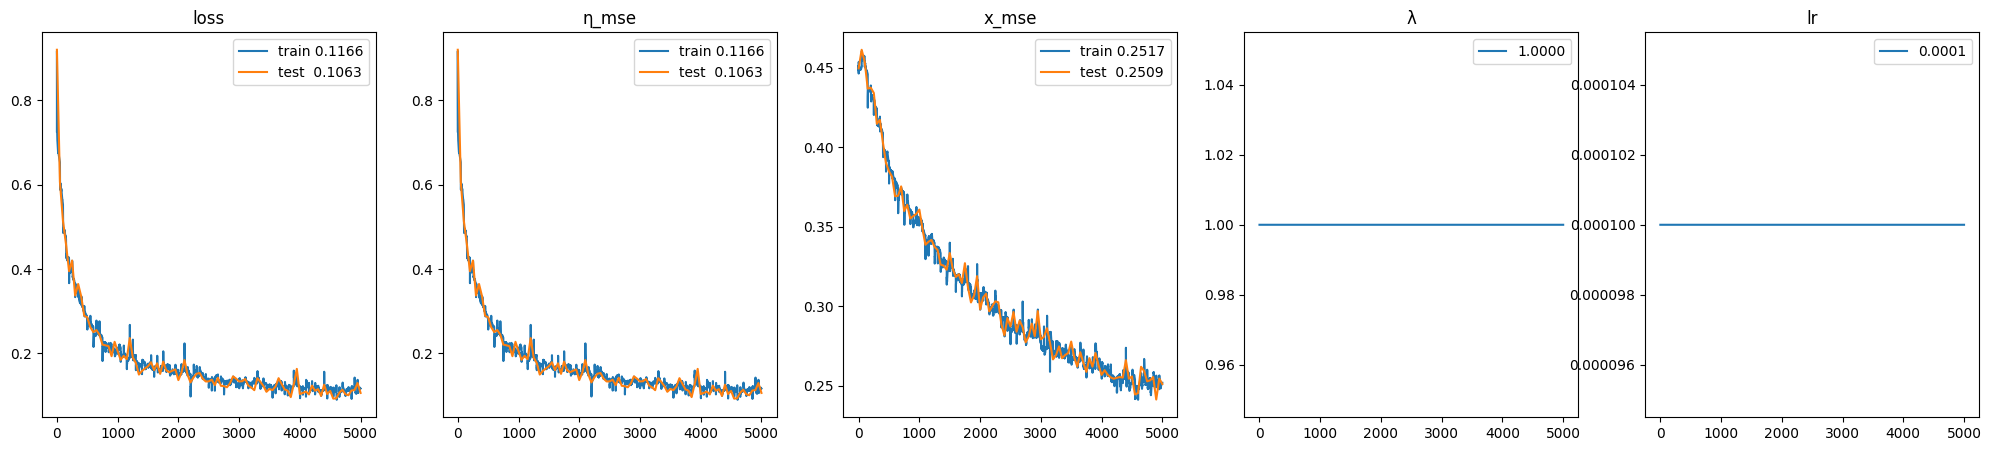

In [14]:
# plot the training history
steps, loss, η_mse, x_mse, λ, lr = history.collect(
    "steps", "loss", "η_mse", "x_mse", "λ", "lr"
)
steps_test, loss_test, η_mse_test, x_mse_test = history.collect(
    "steps", "loss_test", "η_mse_test", "x_mse_test"
)

n_plots = 5
fig, axs = plt.subplots(1, n_plots, figsize=(5 * n_plots, 5))

axs[0].plot(steps, loss, label=f"train {loss[-1]:.4f}")
axs[0].plot(steps_test, loss_test, label=f"test  {loss_test[-1]:.4f}")
axs[0].legend()
axs[0].set_title("loss")

axs[1].plot(steps, η_mse, label=f"train {η_mse[-1]:.4f}")
axs[1].plot(steps_test, η_mse_test, label=f"test  {η_mse_test[-1]:.4f}")
axs[1].legend()
axs[1].set_title("η_mse")

axs[2].plot(steps, x_mse, label=f"train {x_mse[-1]:.4f}")
axs[2].plot(steps_test, x_mse_test, label=f"test  {x_mse_test[-1]:.4f}")
axs[2].legend()
axs[2].set_title("x_mse")

axs[3].plot(steps, λ, label=f"{λ[-1]:.4f}")
axs[3].legend()
axs[3].set_title("λ")

axs[4].plot(steps, lr, label=f"{lr[-1]:.4f}")
axs[4].legend()
axs[4].set_title("lr")

plt.show()

## Self-supervised

In [86]:
train_ds, val_ds = get_data(dataset_config)

INFO:absl:Load dataset info from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Fields info.[citation, splits, supervised_keys, module_name] from disk and from code do not match. Keeping the one from code.
INFO:absl:Reusing dataset mnist (/homes/jua23/tensorflow_datasets/mnist/3.0.1)
INFO:absl:Constructing tf.data.Dataset mnist for split _EvenSplit(split='train[10000:]', index=0, count=1, drop_remainder=False), from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Features before preprocessing: {'image': 'uint8[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op ValueRange(vmin=-1, vmax=1, in_min=0, in_max=255.0, clip_values=False, key='image', key_result=None):
{'image': 'float32[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}


INFO:absl:Features after op RandomRotate(θ_min=-3.141592653589793, θ_max=3.141592653589793, fill_mode='nearest', fill_value=-1, key='image', key_result=None, rng_key='rng'):
{'image': 'float32[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op Keep(keys=['image']):
{'image': 'float32[28, 28, 1]'}
INFO:absl:Features after preprocessing: {'image': 'float32[28, 28, 1]'}
INFO:absl:Constructing tf.data.Dataset mnist for split _EvenSplit(split='train[:10000]', index=0, count=1, drop_remainder=False), from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Features before preprocessing: {'image': 'uint8[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op ValueRange(vmin=-1, vmax=1, in_min=0, in_max=255.0, clip_values=False, key='image', key_result=None):
{'image': 'float32[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op RandomRotate(θ_min=-3.141592653589793, θ_max=3.141592653589793, fill_mode='nearest

In [87]:
ss_model = MyModel()

ss_variables = ss_model.init(init_rng, jnp.empty((28, 28, 1)), train=False)

# parameter_overview.log_parameter_overview(ss_variables)

def update_params(ss_params, state_params):
    for key in ss_params.keys():
        if "Dense_5" in key:
            continue
        if isinstance(ss_params[key], dict) and isinstance(state_params[key], dict):
            update_params(ss_params[key], state_params[key])
        elif ss_params[key].shape == state_params[key].shape:
            ss_params[key] = state_params[key]

# update_params(ss_variables["params"], state.params)

parameter_overview.log_parameter_overview(ss_variables)

INFO:absl:
+-----------------------+--------------+-----------+-----------+--------+
| Name                  | Shape        | Size      | Mean      | Std    |
+-----------------------+--------------+-----------+-----------+--------+
| params/Dense_0/bias   | (2048,)      | 2,048     | 0.0       | 0.0    |
| params/Dense_0/kernel | (784, 2048)  | 1,605,632 | 1.05e-05  | 0.0357 |
| params/Dense_1/bias   | (1024,)      | 1,024     | 0.0       | 0.0    |
| params/Dense_1/kernel | (2048, 1024) | 2,097,152 | 1.31e-05  | 0.0221 |
| params/Dense_2/bias   | (1024,)      | 1,024     | 0.0       | 0.0    |
| params/Dense_2/kernel | (1024, 1024) | 1,048,576 | -6.31e-06 | 0.0313 |
| params/Dense_3/bias   | (1024,)      | 1,024     | 0.0       | 0.0    |
| params/Dense_3/kernel | (1024, 1024) | 1,048,576 | 1.18e-05  | 0.0312 |
| params/Dense_4/bias   | (1024,)      | 1,024     | 0.0       | 0.0    |
| params/Dense_4/kernel | (1024, 1024) | 1,048,576 | 1.47e-05  | 0.0313 |
| params/Dense_5/bias   | (

In [88]:
# def map_nested_fn(fn):
#   '''Recursively apply `fn` to the key-value pairs of a nested dict'''
#   def map_fn(nested_dict):
#     return {k: (map_fn(v) if isinstance(v, dict) else fn(k, v))
#             for k, v in nested_dict.items()}
#   return map_fn

# params = {'linear_1': {'w': jnp.zeros((5, 6)), 'b': jnp.zeros(5)},
#           'linear_2': {'w': jnp.zeros((6, 1)), 'b': jnp.zeros(1)}}
# gradients = jax.tree_util.tree_map(jnp.ones_like, params)  # dummy gradients

# label_fn = map_nested_fn(lambda k, _: k)
# tx = optax.multi_transform({'w': optax.adam(1.0), 'b': optax.sgd(1.0)},
#                            label_fn)
# state = tx.init(params)
# updates, new_state = tx.update(gradients, state, params)
# new_params = optax.apply_updates(params, updates)

In [89]:
TOTAL_STEPS = 20_000
LR = 1e-4
N_SAMPLES = 5
POLYAK_STEP_SIZE = None

from flax import traverse_util

def lr_schedule(init_lr, peak_mult, final_mult, peak_steps): 
    return optax.warmup_cosine_decay_schedule(
        init_lr, init_lr*peak_mult, peak_steps, TOTAL_STEPS, end_value=init_lr*final_mult
    )

# partition_optimizers = {
#     'fast': optax.inject_hyperparams(optax.adamw)(lr_schedule(1e-4, 3, 1/1000, TOTAL_STEPS//10)),
#     'slow': optax.inject_hyperparams(optax.adamw)(lr_schedule(1e-6, 100, 1/10, TOTAL_STEPS//3)),
# }
# param_partitions = flax.core.freeze(traverse_util.path_aware_map(
#   lambda path, v: 'fast' if ('Dense_5' in path or 'Dense_0' in path) else 'slow', ss_variables["params"]))
# tx = optax.multi_transform(partition_optimizers, lambda dict: {k: 'fast' if ('Dense_5' in k or 'Dense_0' in k) else 'slow' for k in dict.keys()})

def clipped_adamw(learning_rate, norm):
    return optax.MultiSteps(optax.chain(
        optax.clip_by_global_norm(norm),
        optax.adamw(learning_rate=learning_rate)
    ), 1)

ss_state = TrainState.create(
    apply_fn=ss_model.apply,
    params=ss_variables["params"],
    # tx=optax.inject_hyperparams(optax.adamw)(lr_schedule(LR, 3, 1/1000, TOTAL_STEPS//10)),
    tx=optax.inject_hyperparams(clipped_adamw)(lr_schedule(LR, 3, 1/30, TOTAL_STEPS//10), 2.),  # best
    # tx=optax.inject_hyperparams(clipped_adamw)(lr_schedule(LR, 10, 1/300, TOTAL_STEPS//10), 2.),  # better for longer training runs
    # tx=tx,
    metrics=Metrics.empty(),
    rng=state_rng,
    λ_schedule=optax.cosine_decay_schedule(1, TOTAL_STEPS, 1),
    polyak_step_size=POLYAK_STEP_SIZE,
)

In [90]:
def loss_fn(
    x, params, state, step_rng, train, n_samples, τ
):
    """Self-supervised loss function. 
    
    The loss can be summarised with the following diagram

            x ------- -η_x -----> x_hat
            |                       |
            |                       v
         η_rand                    mse
            |                       ∧
            ∨                       |
         x_rand --- -η_x_rand ---> x_hat'.

    However, implementing this directly requires doing 3 affine transformations, which adds 'blur' to the image.
    So instead we note that the diagram above is equivalent to

            x --------> mse <------- x'
            |                        ∧
            |                        |
         η_rand                     η_x
            |                        |
            v                        |
         x_rand --- -η_x_rand ---> x_hat'.

    Finally, this computation can be simplified to

            x --------> mse <-------- x'
            |                         ∧
            └ η_rand - η_x_rand + η_x ┘

    which contains only a single transformation.

    """
    rng_local = random.fold_in(step_rng, lax.axis_index("batch"))
    rng_dropout, rng_η = random.split(rng_local)

    def per_sample_loss(rng):
        η_x = state.apply_fn({"params": params}, x, train, rngs={"dropout": rng_dropout})

        Η_rand = distrax.Uniform(
            low=-BOUNDS_ARRAY * state.λ,
            high=BOUNDS_ARRAY * state.λ
        )
        η_rand = Η_rand.sample(seed=rng, sample_shape=())

        # def weighted_uniform_sample(rng):
        #     rng_1, rng_2 = random.split(rng)

        #     mask = jnp.array([True, True, False, True, True])

        #     def _weight_fn(samples):
        #         # Compute the distance of each sample from the extreme values
        #         distance = jnp.minimum(jnp.abs(samples - BOUNDS_ARRAY), jnp.abs(samples + BOUNDS_ARRAY))
        #         # Compute the weights based on the distance
        #         # weights = jnp.prod((1 - distance / BOUNDS_ARRAY)[:,mask], axis=-1)
        #         weights = jnp.where(mask, 1 - distance / BOUNDS_ARRAY, 1).prod(axis=-1)
        #         return weights

        #     # Generate a fixed number of uniform samples
        #     samples = Η_rand.sample(seed=rng_1, sample_shape=(1000,))
        #     # Compute the weights based on the distance from the extreme values
        #     weights = _weight_fn(samples)
        #     # Apply the temperature to the weights
        #     weights = jnp.power(weights, 1.0 / τ)
        #     # Normalize the weights
        #     weights /= jnp.sum(weights)
        #     # Resample the samples with the computed weights
        #     resampled_samples = distrax.Categorical(probs=weights).sample(seed=rng_2, sample_shape=())
        #     return jnp.take(samples, resampled_samples, axis=0)

        # η_rand = weighted_uniform_sample(rng)

        x_rand = transform_image(x, η_rand)
        η_x_rand = state.apply_fn({"params": params}, x_rand, train, rngs={"dropout": rng_dropout})

        x_mse = optax.squared_error(x, transform_image(x, η_rand - η_x_rand + η_x)).mean()
        η_mse = optax.squared_error(η_rand - η_x_rand + η_x).mean()

        loss = x_mse

        difficulty = optax.squared_error(x, x_rand).mean()

        return loss, x_mse, η_mse, difficulty
    
    rngs = random.split(rng_η, n_samples)
    loss, x_mse, η_mse, difficulty = jax.vmap(per_sample_loss)(rngs)
    
    # do a weighted average based on the difficulty of the sample
    # weights = jax.nn.softmax(difficulty)
    weights = difficulty / difficulty.sum()
    loss, x_mse, η_mse = jax.tree_map(lambda x: (x * weights).sum(axis=0), (loss, x_mse, η_mse))

    # loss, x_mse, η_mse = jax.tree_map(lambda x: x.mean(axis=0), (loss, x_mse, η_mse))

    return loss, {"loss": loss, "η_mse": η_mse, "x_mse": x_mse}


@jax.jit
def train_step(state, batch):
    step_rng = random.fold_in(state.rng, state.step)

    def batch_loss_fn(params):
        losses, metrics = jax.vmap(loss_fn, in_axes=(0, None, None, None, None, None, None), axis_name="batch")(
            batch["image"][0], params, state, step_rng, True, N_SAMPLES, 2.
        )

        avg_loss = losses.mean(axis=0)

        return avg_loss, metrics

    (_, metrics), grads = jax.value_and_grad(batch_loss_fn, has_aux=True)(state.params)
    state = state.apply_gradients(grads=grads)

    metrics = state.metrics.update(
        **metrics
    )
    logs = ciclo.logs()
    logs.add_stateful_metrics(**metrics.compute())
    logs.add_entry("schedules", "λ", state.λ)
    logs.add_entry("schedules", "lr", state.opt_state.hyperparams["learning_rate"])
    # logs.add_entry("schedules", "lr_fast", state.opt_state.inner_states['fast'][0].hyperparams["learning_rate"])
    # logs.add_entry("schedules", "lr_slow", state.opt_state.inner_states['slow'][0].hyperparams["learning_rate"])
    logs.add_entry("gradients", "grad_norm", optax.global_norm(grads))

    return logs, state.replace(metrics=metrics)


@jax.jit
def eval_step(state, batch):
    step_rng = random.fold_in(state.rng, state.step)

    masks = batch["mask"][0]

    def batch_loss_fn(params):
        losses, metrics = jax.vmap(loss_fn, in_axes=(0, None, None, None, None, None, None), axis_name="batch")(
            batch["image"][0], params, state, step_rng, False, 1, jnp.inf
        )

        avg_loss = (losses * masks).sum(axis=0) / masks.sum(axis=0)

        return avg_loss, metrics

    # _, metrics = batch_loss_fn(state.params)
    _, metrics = batch_loss_fn(state.params if state.avg_params is None else state.avg_params)

    metrics = state.metrics.update(
        **metrics, mask=masks
    )
    logs = ciclo.logs()
    logs.add_stateful_metrics(**metrics.compute())

    return logs, state.replace(metrics=metrics)

In [91]:
ss_state, ss_history, _ = ciclo.train_loop(
    ss_state,
    deterministic_data.start_input_pipeline(train_ds),
    {
        ciclo.on_train_step: [
            train_step
        ],
        ciclo.on_reset_step: reset_metrics,
        ciclo.on_test_step: eval_step,
    },
    test_dataset=lambda: deterministic_data.start_input_pipeline(val_ds),
    epoch_duration=TOTAL_STEPS // 100,
    callbacks=[
        ciclo.keras_bar(total=TOTAL_STEPS),
    ],
    stop=TOTAL_STEPS + 1,
)

20000/20000 [==============================] - 407s 20ms/step - loss: 0.1889 - x_mse: 0.1889 - η_mse: 2.1483 - loss_test: 0.1849 - x_mse_test: 0.1849 - η_mse_test: 2.1745


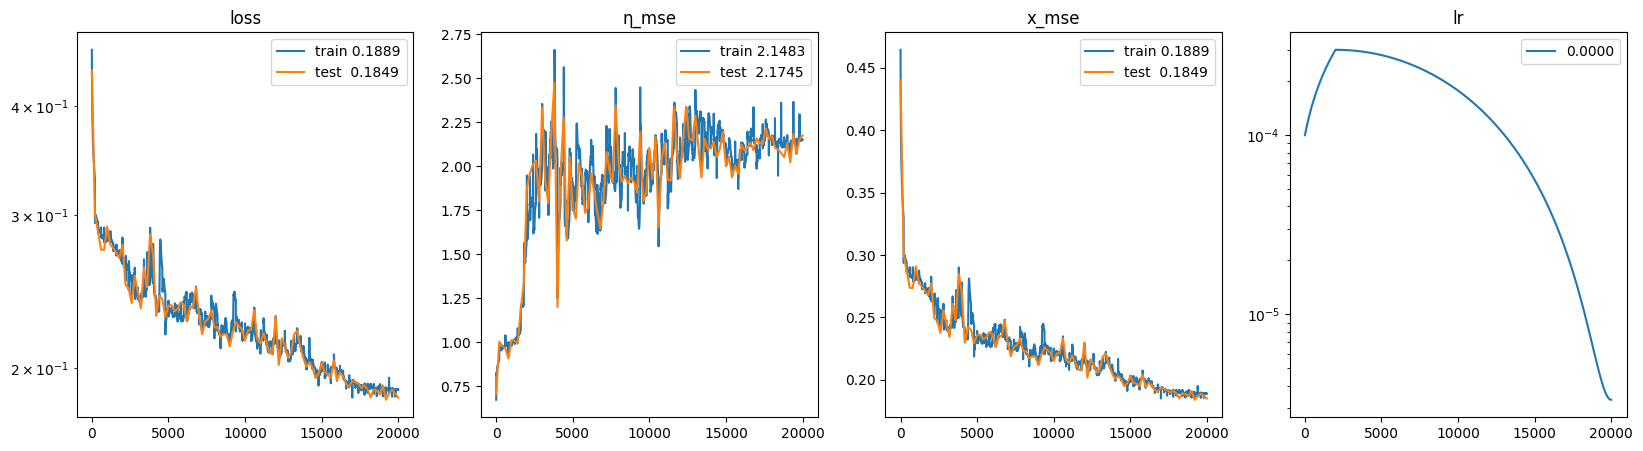

In [92]:
# plot the training history
steps, loss, η_mse, x_mse, λ, lr, grad_norm = ss_history.collect(
    "steps", "loss", "η_mse", "x_mse", "λ", "lr", "grad_norm"
)
steps_test, loss_test, η_mse_test, x_mse_test = ss_history.collect(
    "steps", "loss_test", "η_mse_test", "x_mse_test"
)

n_plots = 4
fig, axs = plt.subplots(1, n_plots, figsize=(5 * n_plots, 5))

axs[0].plot(steps, loss, label=f"train {loss[-1]:.4f}")
axs[0].plot(steps_test, loss_test, label=f"test  {loss_test[-1]:.4f}")
axs[0].legend()
axs[0].set_title("loss")
axs[0].set_yscale("log")

axs[1].plot(steps, η_mse, label=f"train {η_mse[-1]:.4f}")
axs[1].plot(steps_test, η_mse_test, label=f"test  {η_mse_test[-1]:.4f}")
axs[1].legend()
axs[1].set_title("η_mse")

axs[2].plot(steps, x_mse, label=f"train {x_mse[-1]:.4f}")
axs[2].plot(steps_test, x_mse_test, label=f"test  {x_mse_test[-1]:.4f}")
axs[2].legend()
axs[2].set_title("x_mse")

axs[3].plot(steps, lr, label=f"{lr[-1]:.4f}")
axs[3].legend()
axs[3].set_title("lr")
axs[3].set_yscale("log")

# axs[4].plot(steps, grad_norm, label=f"{grad_norm[-1]:.4f}")
# axs[4].legend()
# axs[4].set_title("grad_norm")

# axs[4].plot(steps, λ, label=f"{λ[-1]:.4f}")
# axs[4].legend()
# axs[4].set_title("λ")

plt.show()

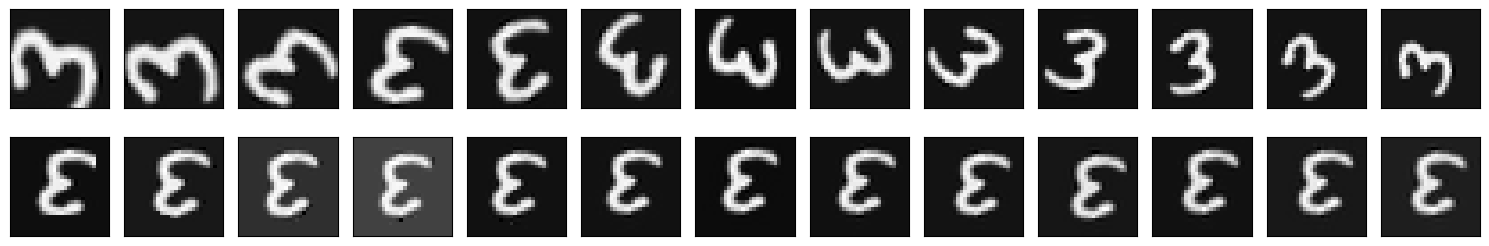

In [93]:
val_iter = deterministic_data.start_input_pipeline(val_ds)
val_batch = next(val_iter)

x_ = val_batch['image'][0][14]

mask = jnp.array([0, 0, 1, 0, 0])

def get_proto(x):
    η = ss_state.apply_fn({"params": ss_state.avg_params if ss_state.avg_params is not None else ss_state.params}, x, train=False)
    xhat = transform_image(x, -η)
    return xhat, η

for mask in [
    # jnp.array([0, 0, 1, 0, 0]),
    # jnp.array([1, 1, 0, 0, 0]),
    # jnp.array([0, 0, 0, 1, 1]),
    jnp.array([1, 1, 1, 1, 1])
]:

    transformed_xs = jax.vmap(transform_image, in_axes=(None, 0))(x_, jnp.linspace(-BOUNDS_ARRAY * mask, BOUNDS_ARRAY * mask, 13))

    xhats, ηs = jax.vmap(get_proto)(transformed_xs)

    fig, axs = plt.subplots(2, len(xhats), figsize=(15, 3))

    for ax, x in zip(axs[0], list(transformed_xs)):
        ax.imshow(x, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])

    for ax, xhat in zip(axs[1], list(xhats)):
        ax.imshow(xhat, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    plt.show()

[]

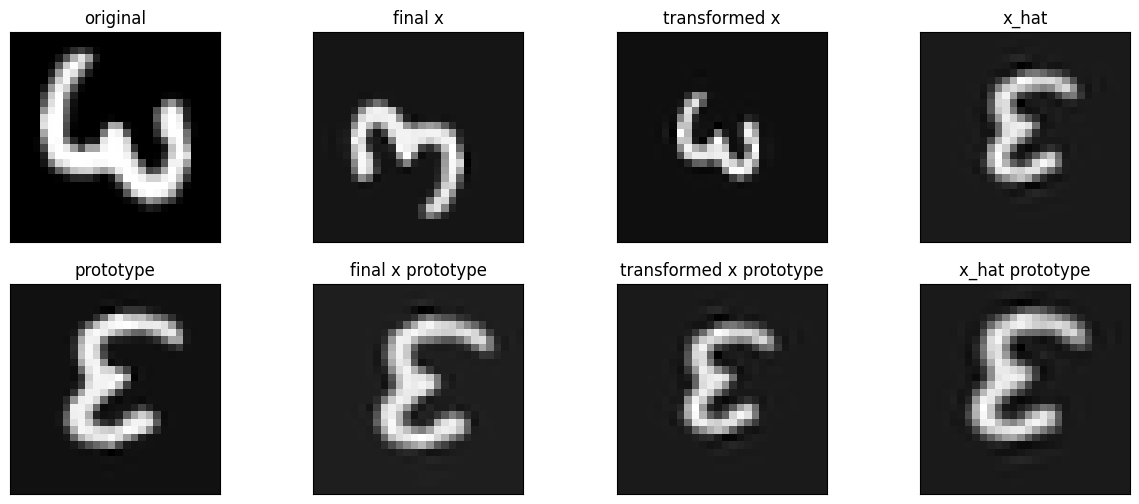

In [94]:
# make a figure with 2 rows and 4 columns
fig, axs = plt.subplots(2, 4, figsize=(15, 6))

# plot the original image
axs[0, 0].imshow(x_, cmap='gray')
axs[0, 0].set_title("original")
axs[0, 0].set_xticks([])
axs[0, 0].set_yticks([])

# plot the corresponding prototype
xhat, η = get_proto(x_)
axs[1, 0].imshow(xhat, cmap='gray')
axs[1, 0].set_title("prototype")
axs[1, 0].set_xticks([])
axs[1, 0].set_yticks([])

# plot x
axs[0, 1].imshow(x, cmap='gray')
axs[0, 1].set_title("final x")
axs[0, 1].set_xticks([])
axs[0, 1].set_yticks([])

# plot the corresponding prototype
xhat, η = get_proto(x)
axs[1, 1].imshow(xhat, cmap='gray')
axs[1, 1].set_title("final x prototype")
axs[1, 1].set_xticks([])
axs[1, 1].set_yticks([])

# transform again and plot the result
xx = transform_image(x, BOUNDS_ARRAY)
axs[0, 2].imshow(xx, cmap='gray')
axs[0, 2].set_title("transformed x")
axs[0, 2].set_xticks([])
axs[0, 2].set_yticks([])

# plot the corresponding prototype
xhat, η = get_proto(xx)
axs[1, 2].imshow(xhat, cmap='gray')
axs[1, 2].set_title("transformed x prototype")
axs[1, 2].set_xticks([])
axs[1, 2].set_yticks([])

# use that xhat as x
axs[0, 3].imshow(xhat, cmap='gray')
axs[0, 3].set_title("x_hat")
axs[0, 3].set_xticks([])
axs[0, 3].set_yticks([])

# plot the corresponding prototype
xhat, η = get_proto(xhat)
axs[1, 3].imshow(xhat, cmap='gray')
axs[1, 3].set_title("x_hat prototype")
axs[1, 3].set_xticks([])
axs[1, 3].set_yticks([])


## Resampling code

In [95]:
def weighted_uniform_sampling(key, num_samples, bounds, weight_fn, temperature=1., mask=None):
    # Generate a fixed number of uniform samples
    samples = distrax.Uniform(low=-bounds, high=bounds).sample(seed=key, sample_shape=(num_samples*1000,))
    # Compute the weights based on the distance from the extreme values
    weights = weight_fn(samples, bounds, mask)
    # Apply the temperature to the weights
    weights = jnp.power(weights, 1.0 / temperature)
    # Normalize the weights
    weights /= jnp.sum(weights)
    # Resample the samples with the computed weights
    resampled_samples = distrax.Categorical(probs=weights).sample(seed=key, sample_shape=(num_samples,))
    return jnp.take(samples, resampled_samples, axis=0)

def weight_fn(samples, bounds, mask=None):
    if mask is None:
        mask = jnp.ones_like(bounds)
    mask = jnp.array(mask, dtype=bool)
    # Compute the distance of each sample from the extreme values
    distance = jnp.minimum(jnp.abs(samples - bounds), jnp.abs(samples + bounds))
    # Compute the weights based on the distance
    weights = jnp.where(mask, 1 - distance / bounds, 1).prod(axis=-1)
    return weights

samples = weighted_uniform_sampling(rng, 10, BOUNDS_ARRAY, weight_fn)
samples

Array([[ 0.2136234 ,  0.2329452 ,  1.6852534 ,  0.05451798, -0.20962691],
       [ 0.23280007,  0.21372545,  1.783849  ,  0.1709131 , -0.07764941],
       [-0.23876315, -0.2367773 , -2.7024615 ,  0.20791638, -0.2083779 ],
       [-0.01652765,  0.08712256,  2.989548  , -0.19389427, -0.21614218],
       [-0.23865324, -0.14975685,  2.5481012 ,  0.20497328, -0.20648342],
       [-0.19226778,  0.13995004, -1.2606333 , -0.2199406 , -0.19006175],
       [ 0.17519581,  0.05997324, -1.3852117 ,  0.14805722,  0.15768427],
       [-0.13811475, -0.19542664,  1.2930582 ,  0.2082532 , -0.1118598 ],
       [ 0.19016153,  0.00860667,  2.873442  ,  0.1323883 ,  0.247293  ],
       [ 0.24001324,  0.21788532, -2.650982  , -0.19398361, -0.20169932]],      dtype=float32)

In [96]:
jnp.abs(distrax.Uniform(low=-BOUNDS_ARRAY, high=BOUNDS_ARRAY).sample(seed=rng, sample_shape=(10*1000,))).mean()

Array(0.41388988, dtype=float32)

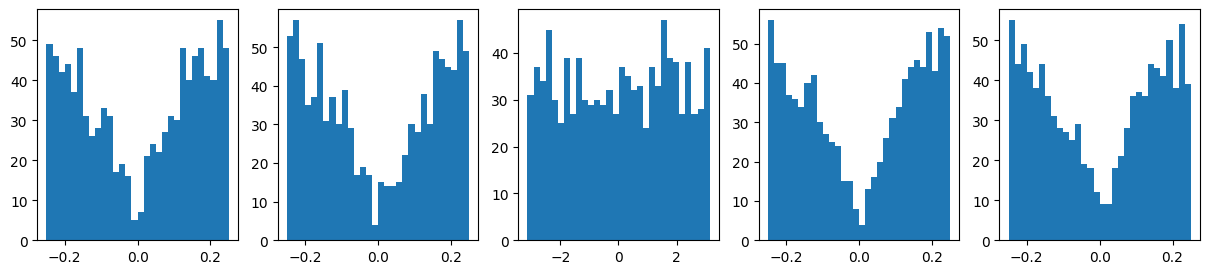

In [97]:
# make a distogram for each dimension
fig, axs = plt.subplots(1, 5, figsize=(15, 3))

samples = weighted_uniform_sampling(rng, 1000, BOUNDS_ARRAY, weight_fn, 2., jnp.array([1, 1, 0, 1, 1]))

for i, ax in enumerate(axs):
    ax.hist(samples[:, i], bins=30)

plt.show()